# Credit Card Transactions Fraud Detection

## **Part II:** Continuing Pre-processing & Feature Selection
**Table of contents:**
1. **Import libraries**
2. **Load data**
3. **Data Splitting** into training and testing sets.
4. **Data Transformation**: Scale numerical variables and encode categorical variables on the training set.
5. **Imbalanced data Handling**: Apply SMOTE to the training set only to handle class imbalance.
6. Save the data for modelling (full feature set)
7. **Feature Selection**: Perform feature selection on the resampled training data.
_(Feature selection should be performed on the dataset that will be used to fit the model.)_
    - 7.1. Try Feature Importance from Tree-based Models - Embedded Methods.
    - 7.2. Try Lasso Regression (L1 Regularization)  - Embedded Methods
    - 7.3. Try Recursive Feature Elimination (RFE) - Wrapper Methods
    - 7.4. Try Correlation Matrix with Heatmap - Filter Methods
    - 7.5. Try Variance Threshold - Filter Methods

# 1. Import libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
import warnings
warnings.filterwarnings("ignore")

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 2. Load data

In [2]:
#  Load data
df = pd.read_csv('../data/fraudTrain_preprocessed_for_machinelearning.csv')

In [3]:
df.head()

,category,amt,gender,city,state,zip,city_pop,job,is_fraud,transaction_hour,transaction_day_of_week,transaction_day_of_month,transaction_month,age,distance
0,misc_net,4.97,F,Moravian Falls,NC,28654,3495,"Psychologist, counselling",0,0,1,1,1,31,48.947783
1,grocery_pos,107.23,F,Orient,WA,99160,149,Special educational needs teacher,0,0,1,1,1,41,18.775736
2,entertainment,220.11,M,Malad City,ID,83252,4154,Nature conservation officer,0,0,1,1,1,57,67.172035
3,gas_transport,45.00,M,Boulder,MT,59632,1939,Patent attorney,0,0,1,1,1,52,59.455974
4,misc_pos,41.96,M,Doe Hill,VA,24433,99,Dance movement psychotherapist,0,0,1,1,1,33,48.282030


In [4]:
df.shape

(1296675, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   category                  1296675 non-null  object 
 1   amt                       1296675 non-null  float64
 2   gender                    1296675 non-null  object 
 3   city                      1296675 non-null  object 
 4   state                     1296675 non-null  object 
 5   zip                       1296675 non-null  int64  
 6   city_pop                  1296675 non-null  int64  
 7   job                       1296675 non-null  object 
 8   is_fraud                  1296675 non-null  int64  
 9   transaction_hour          1296675 non-null  int64  
 10  transaction_day_of_week   1296675 non-null  int64  
 11  transaction_day_of_month  1296675 non-null  int64  
 12  transaction_month         1296675 non-null  int64  
 13  age                       1

In [6]:
df.nunique()

category                         14
amt                           52928
gender                            2
city                            894
state                            51
zip                             970
city_pop                        879
job                             494
is_fraud                          2
transaction_hour                 24
transaction_day_of_week           7
transaction_day_of_month         31
transaction_month                12
age                              83
distance                    1296675
dtype: int64

# 3. Split data

In [7]:
# Define Features and Target
X = df.drop('is_fraud', axis=1)  # Features
y = df['is_fraud']               # Target

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train.shape , y_train.shape,   X_test.shape , y_test.shape

((1037340, 14), (1037340,), (259335, 14), (259335,))

# 4. Transform Data
Transform the training data by 
- scaling numerical variables and
- encoding categorical variables.

Challenge: MemoryError

To address the MemoryError, we need to make the data transformation process more memory-efficient. Here are a few strategies:

1. Reduce the number of categories: Encoding categorical features with many unique values can cause memory issues. We can reduce the cardinality of categorical variables by grouping less frequent categories into an "other" category.

2. Use a different encoding method: Instead of OneHotEncoding, we can use TargetEncoder or FrequencyEncoder which are more memory efficient.

3. Downsampling the majority class: Downsample the majority class before applying SMOTE. This will reduce the size of the dataset, making it more manageable.

4. Batch processing: Process the data in smaller batches instead of loading everything into memory at once.

In [10]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.to_list()
categorical_features = X.select_dtypes(include=['object']).columns.to_list()

In [11]:
numerical_features

['amt',
 'zip',
 'city_pop',
 'transaction_hour',
 'transaction_day_of_week',
 'transaction_day_of_month',
 'transaction_month',
 'age',
 'distance']

In [12]:
categorical_features

['category', 'gender', 'city', 'state', 'job']

Note: Frequency Encoding (CountEncoder) replaces each category with its frequency in the dataset.

Note: zip is categorical feature???

In [13]:
# Defining numerical and categorical columns
numerical_features = ['amt', 'city_pop', 'transaction_hour', 'transaction_day_of_week', 'transaction_day_of_month', 'transaction_month', 'age', 'distance']
categorical_features = ['category', 'gender', 'city', 'state', 'zip', 'job']


# ######## Build transformation pipelines
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# # Preprocessing for categorical data
# categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Preprocessing for categorical data using Target Encoding instead of OnehotEncoder
categorical_transformer = ce.TargetEncoder(cols=categorical_features)

# Combining numerical and categorical transformers
preprocessor_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')              #  Keep other columns unchanged

In [14]:
######## Apply transformation pipeline
X_train_transformed = preprocessor_pipeline.fit_transform(X_train, y_train)  # Fit and transform on training dataset   # return array (not csr_matrix)
X_test_transformed = preprocessor_pipeline.transform(X_test)        # Transform on testing dataset            # return array (not csr_matrix)

In [15]:
X_train_transformed

array([[-1.18625831e-01, -2.93624201e-01, -1.43891298e+00, ...,
         6.65198436e-03,  4.83792937e-03,  3.65726228e-03],
       [-3.60128486e-01, -2.85488921e-01,  9.08057743e-01, ...,
         5.07306532e-03,  4.42695524e-03,  7.76778414e-03],
       [ 5.67253525e+00, -2.93571224e-01,  1.74629393e-01, ...,
         4.93485985e-03,  2.82599919e-03,  6.92520776e-03],
       ...,
       [-3.41349206e-02, -2.93147408e-01,  7.61372073e-01, ...,
         5.57917109e-03,  5.50458716e-03,  2.22002960e-03],
       [-2.33614967e-01, -1.91971285e-01,  1.74629393e-01, ...,
         4.59595960e-03,  1.79748352e-03,  5.09956289e-03],
       [ 4.26776684e-01,  9.60738540e-01,  1.34811475e+00, ...,
         4.71529187e-03,  0.00000000e+00,  0.00000000e+00]])

In [16]:
# List of features after transformation
list(preprocessor_pipeline.get_feature_names_out())

['num__amt',
 'num__city_pop',
 'num__transaction_hour',
 'num__transaction_day_of_week',
 'num__transaction_day_of_month',
 'num__transaction_month',
 'num__age',
 'num__distance',
 'cat__category',
 'cat__gender',
 'cat__city',
 'cat__state',
 'cat__zip',
 'cat__job']

In [17]:
# Check shape
X_train_transformed.shape, y_train.shape,   X_test_transformed.shape, y_test.shape

((1037340, 14), (1037340,), (259335, 14), (259335,))

In [18]:
# Check type
type(X_train_transformed), type(y_train),  type(X_test_transformed),  type(y_test)

(numpy.ndarray,
 pandas.core.series.Series,
 numpy.ndarray,
 pandas.core.series.Series)

In [19]:
# AUDIT - Checking if number of columns appears correctly after data tranformation pipeline:

print("Number of columns of X before transformation:", X_train.shape[1])
print("Number of columns of X after transformation:", X_train_transformed.shape[1])
print("Does number of columns appear correctly after data tranformation pipeline?:") 
X_train.shape[1] == (X_train_transformed.shape[1]
                    )
## Below use for onehotencoder
# X_train.shape[1] == (X_train_transformed.shape[1] - df['category'].nunique() +1  
#                                                   - df['gender'].nunique() + 1 
#                                                   - df['city'].nunique() + 1 
#                                                   - df['state'].nunique() + 1 
#                                                   - df['job'].nunique() + 1
#                     )

Number of columns of X before transformation: 14
Number of columns of X after transformation: 14
Does number of columns appear correctly after data tranformation pipeline?:


True

# 5. Handle imbalanced data

In [20]:
# OVERSAMPLING to handle imbalanced dataset

# Apply SMOTE to the transformed training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [21]:
# Check shape
X_train_resampled.shape , y_train_resampled.shape ,    X_test_transformed.shape, y_test.shape

((2062670, 14), (2062670,), (259335, 14), (259335,))

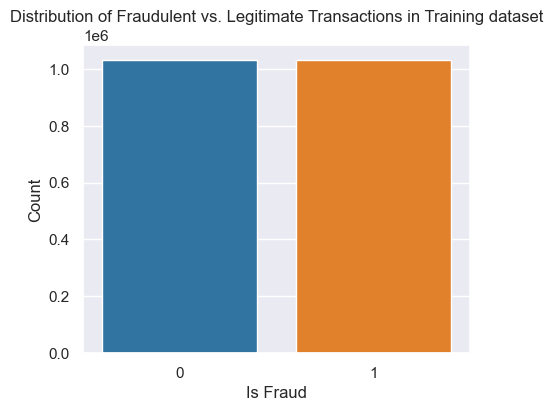

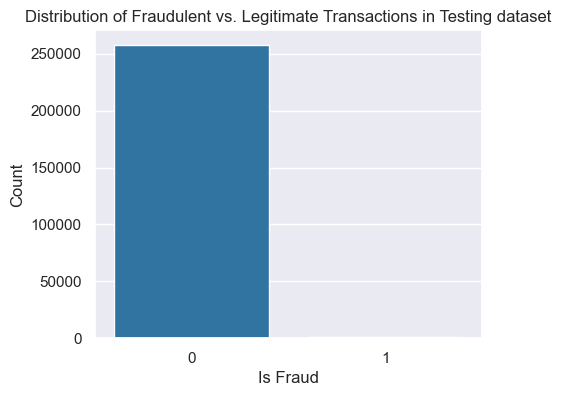

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 4))
sns.countplot(x=y_train_resampled, palette='tab10')
plt.title('Distribution of Fraudulent vs. Legitimate Transactions in Training dataset')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 4))
sns.countplot(x=y_test, palette='tab10')
plt.title('Distribution of Fraudulent vs. Legitimate Transactions in Testing dataset')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

***Commment***:

Training dataset becomes balanced and ready for training phase.

In [23]:
# Check type
type(X_train_resampled), type(y_train_resampled),  type(X_test_transformed),  type(y_test)

(numpy.ndarray,
 pandas.core.series.Series,
 numpy.ndarray,
 pandas.core.series.Series)

In [24]:
######## Convert Numpy array to DataFrame
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=preprocessor_pipeline.get_feature_names_out())
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=preprocessor_pipeline.get_feature_names_out())

In [25]:
X_train_resampled_df.head()

,num__amt,num__city_pop,num__transaction_hour,num__transaction_day_of_week,num__transaction_day_of_month,num__transaction_month,num__age,num__distance,cat__category,cat__gender,cat__city,cat__state,cat__zip,cat__job
0,-0.118626,-0.293624,-1.438913,0.422626,-0.746609,0.543626,-1.037192,-1.525742,0.002916,0.005233,4.837929e-03,0.006652,4.837929e-03,0.003657
1,-0.360128,-0.285489,0.908058,0.877514,1.518615,-0.041775,0.170654,-0.048473,0.002508,0.005233,2.222222e-03,0.005073,4.426955e-03,0.007768
2,5.672535,-0.293571,0.174629,1.332402,0.272742,0.543626,-0.634576,0.440885,0.007255,0.005233,3.794038e-03,0.004935,2.825999e-03,0.006925
3,-0.169753,-0.293429,1.201429,-1.396925,-0.293564,-0.334476,0.400720,-0.574901,0.001616,0.006459,8.443908e-03,0.005742,8.443908e-03,0.008444
4,-0.237244,-0.271659,0.174629,0.877514,0.159480,0.543626,-1.439807,1.286029,0.002508,0.005233,1.285382e-18,0.004803,1.285382e-18,0.005465


In [26]:
X_test_transformed_df.head()

,num__amt,num__city_pop,num__transaction_hour,num__transaction_day_of_week,num__transaction_day_of_month,num__transaction_month,num__age,num__distance,cat__category,cat__gender,cat__city,cat__state,cat__zip,cat__job
0,-0.405589,-0.287532,-1.438913,-0.487149,1.518615,-0.627176,1.148435,0.965022,0.014574,0.005233,0.004400,0.005579,0.004400,0.004087
1,-0.009494,-0.178356,-0.265428,-0.942037,-0.746609,-0.627176,0.113138,0.761583,0.004781,0.005233,0.000419,0.005742,0.000419,0.000419
2,0.334645,0.027128,0.614686,0.422626,1.292093,-0.919877,0.515753,-0.078257,0.001706,0.006459,0.000000,0.005371,0.000000,0.013575
3,0.142869,-0.219999,-0.998856,0.422626,0.499264,-0.919877,2.011182,1.377634,0.004781,0.005233,0.005700,0.007049,0.005700,0.007203
4,-0.056229,-0.275847,-1.145542,-1.396925,0.612525,1.129027,0.515753,-0.472976,0.013835,0.005233,0.012225,0.002283,0.012225,0.005699


In [27]:
y_train_resampled.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

In [28]:
y_test.head()

1161537    0
192923     0
1086283    0
1069482    0
689806     0
Name: is_fraud, dtype: int64

# 6. Save the data for modelling

In [29]:
# Save to csv files
X_train_resampled_df.to_csv('../data/X_train_full_features.csv', index=False)
X_test_transformed_df.to_csv('../data/X_test_full_features.csv', index=False)
y_train_resampled.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

In [30]:
# # Save csr_matrix to .pkl
# joblib.dump(X_train_resampled, '../data/X_train_full_features.pkl')
# joblib.dump(X_test_transformed, '../data/X_test_full_features.pkl')
# joblib.dump(y_train_resampled, '../data/y_train.pkl')
# joblib.dump(y_test, '../data/y_test.pkl')

In [31]:
#### Combine Tranformation and SMOTE (STEP 4 & 5 TOGETHER)

# # Defining numerical and categorical columns
# numerical_features = ['amt', 'city_pop', 'transaction_hour', 'transaction_day_of_week', 'transaction_day_of_month', 'transaction_month', 'age', 'distance']
# categorical_features = ['category', 'gender', 'city', 'state', 'zip', 'job']

# # Preprocessing for numerical data
# numerical_transformer = StandardScaler()

# # # Preprocessing for categorical data
# # categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# # Preprocessing for categorical data using Target Encoding instead of OnehotEncoder
# categorical_transformer = ce.TargetEncoder(cols=categorical_features)

# # Combining numerical and categorical transformers
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ], remainder='passthrough')

# # Define SMOTE
# smote = SMOTE(random_state=42)

# # Creating the final pipeline
# pipeline = ImbPipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('smote', smote)
# ])

#===============
# # Apply transformations and SMOTE on the training data
# X_train_transformedresampled, y_train_transformedresampled = pipeline.fit_resample(X_train, y_train)

# # Transform the test data (without SMOTE)
# X_test_transformed = preprocessor.transform(X_test)
#===============
# # Check shape after transformation and SMOTE
# X_train_transformedresampled.shape , y_train_transformedresampled.shape,   X_test_transformed.shape , y_test.shape
#===============
# # Check type
# type(X_train_transformedresampled), type(y_train_transformedresampled),  type(X_test_transformed),  type(y_test)
#===============
######## Convert Numpy array to DataFrame
# X_train_transformedresampled_df = pd.DataFrame(X_train_transformedresample, columns=preprocessor_pipeline.get_feature_names_out())
# X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=preprocessor_pipeline.get_feature_names_out())

# _______________________________
# 7. Feature Selection
Perform feature selection **on the resampled training data**

Feature selection is a crucial step in building a machine learning model, as it helps improve model performance, reduce overfitting, and decrease computation time. Here are some tips and techniques for effective feature selection:

- Model-based Methods (Feature Importance from Models): Use feature importance scores from models like Random Forest, Gradient Boosting, or XGBoost.
- Regularization Methods:  Use Lasso regression (L1 regularization) to penalize less important features.
- Statistical Methods: Chi-square, ANOVA. Use statistical tests to determine the relationship between features and the target variable.
  

- Recursive Feature Elimination (RFE): Use RFE to recursively remove features and build models to identify the most important features.
- Dimensionality Reduction Techniques: Use PCA (Principal Component Analysis) or other techniques to reduce feature dimensions.
- Domain Knowledge: Use domain knowledge to select features that are known to be important.

In [32]:
#  Load data
X_train = pd.read_csv('../data/X_train_full_features.csv')   
X_test = pd.read_csv('../data/X_test_full_features.csv')    
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

## 7.1. Try Feature Importance from Tree-based Models - Embedded Methods

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Define and Fit the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
importance = rf.feature_importances_   

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': X_train.columns,
                                   'Importance': importance
                                  }).sort_values(by='Importance', ascending=False)    

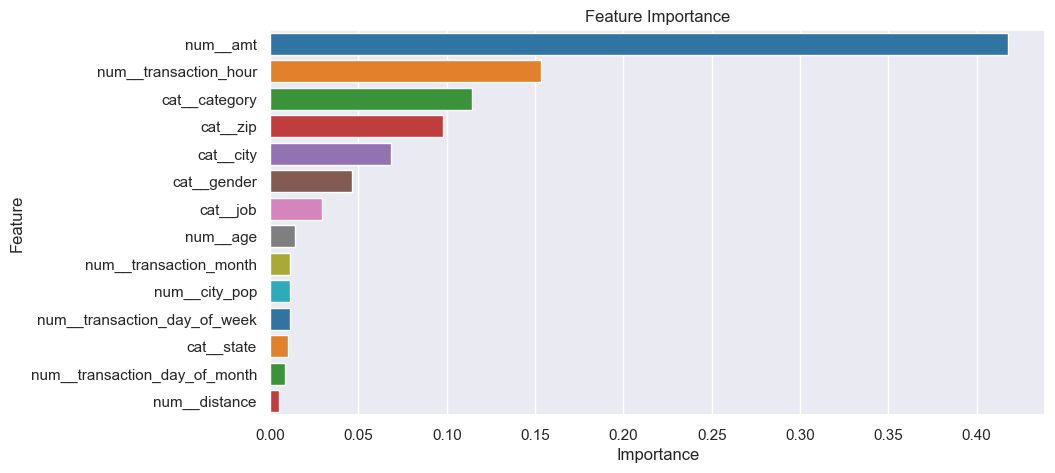

In [34]:
# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='tab10')
plt.title('Feature Importance')
plt.show()

In [37]:
# Select important features using SelectFromModel

from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(rf, threshold="mean", prefit=True)
                        # (RandomForestClassifier(random_state=42))
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get the selected features
selected_features = X_train.columns[(selector.get_support())].to_list()
print(f'Selected features:\n {selected_features}')

Selected features:
 ['num__amt', 'num__transaction_hour', 'cat__category', 'cat__zip']


## 7.2. Try Lasso Regression (L1 Regularization)  - Embedded Methods

In [39]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Define the model with L1 regularization
lasso = LogisticRegression(C=1.0, penalty='l1', solver='liblinear')
lasso.fit(X_train, y_train)

# Get feature importance
importance = lasso.coef_[0]

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': X_train.columns,
                                   'Importance': importance
                                  }).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
12,cat__zip,141.663317
13,cat__job,31.185629
11,cat__state,20.651481
0,num__amt,1.203308
4,num__transaction_day_of_month,0.050872
7,num__distance,0.020225
3,num__transaction_day_of_week,0.018291
6,num__age,-0.099292
1,num__city_pop,-0.099982
2,num__transaction_hour,-0.132090


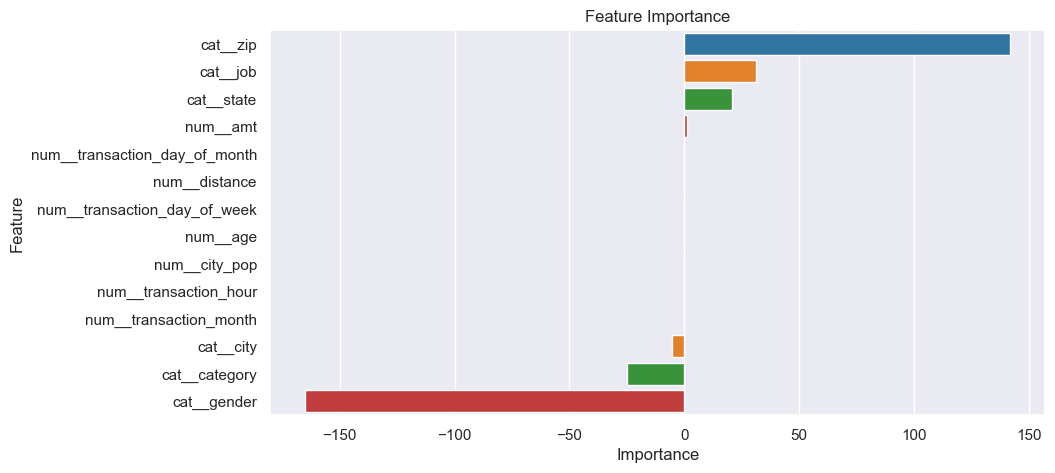

In [40]:
# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='tab10')
plt.title('Feature Importance')
plt.show()

In [41]:
# # Select important features using SelectFromModel
# selector = SelectFromModel(lasso, prefit=True)
# X_train_lasso = selector.transform(X_train)
# X_test_lasso = selector.transform(X_test)

# # Get the selected features
# selected_features = X_train.columns[selector.get_support()].to_list()
# print("Selected features:\n", selected_features)

Selected features:
 ['num__amt', 'num__city_pop', 'num__transaction_hour', 'num__transaction_day_of_week', 'num__transaction_day_of_month', 'num__transaction_month', 'num__age', 'num__distance', 'cat__category', 'cat__gender', 'cat__city', 'cat__state', 'cat__zip', 'cat__job']


## 7.3. Try Recursive Feature Elimination (RFE) - Wrapper Methods

In [42]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create the RFE model and select 10 features
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_].to_list()
print("Selected features:\n", selected_features)

Selected features:
 ['num__amt', 'num__city_pop', 'num__transaction_hour', 'num__transaction_month', 'num__age', 'cat__category', 'cat__city', 'cat__state', 'cat__zip', 'cat__job']


## 7.4. Try Correlation Matrix with Heatmap - Filter Methods

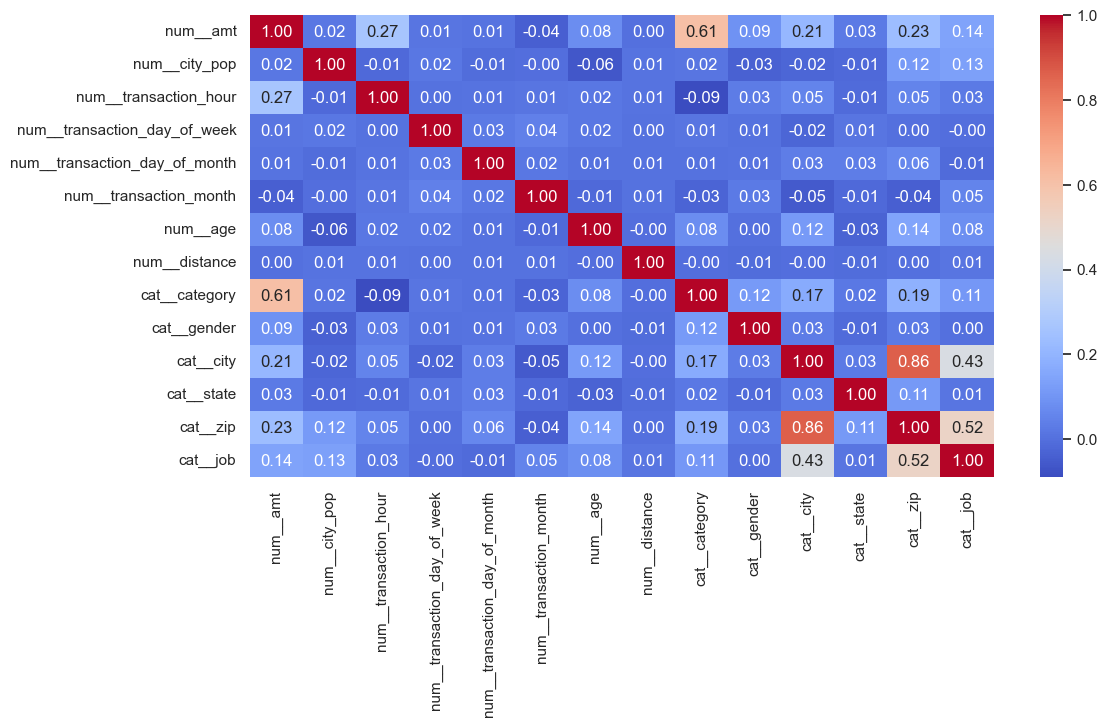

In [43]:
# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

***Comment***:

`zip` & `city` are  highly correlated features (corr=0.86) ===> keep `zip`, remove `city` (because score of zip is higher than city according to above charts) to avoid multicolinearity.

(Remove highly correlated features (threshold = 0.8))

## 7.5. Variance Threshold - Filter Methods

In [45]:
from sklearn.feature_selection import VarianceThreshold

# Apply Variance Threshold
def variance_threshold_selector(data, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

X_train_vt = variance_threshold_selector(X_train)
X_test_vt = X_test[X_train_vt.columns]

In [47]:
X_train_vt.columns

Index(['num__amt', 'num__city_pop', 'num__transaction_hour',
       'num__transaction_day_of_week', 'num__transaction_day_of_month',
       'num__transaction_month', 'num__age', 'num__distance'],
      dtype='object')

### Comment

- According to 5 methods above, it seems that `transaction amount`, `transaction_hour`, `transaction category`, `zip code`, `gender`, `job`, `state`.

- Now, we have an insight at the important features, but I haven't decided which subset to choose right now. I will try different subsets after training the model with the full feature set first (in the next notebook).